<a href="https://colab.research.google.com/github/binlee52/Individual-Research-1/blob/master/Script_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Google drive 연결
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install pip==18.0

In [0]:
%%writefile setup.py

setup.py

In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

In [0]:
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install -v --no-cache-dir apex

In [0]:
!sh setup.sh

In [0]:
pip install transformers==2.10.0

In [0]:
pip install simpletransformers

In [0]:
from transformers import *

In [0]:
import tensorflow as tf
import tensorflow_datasets
import pandas as pd

# Load 
Load train set and evaluate set.

In [0]:
train_link = '/content/drive/My Drive/Colab Notebooks/train/test_data2.csv'
train_df = pd.read_csv(train_link, dtype = {'sentence': str, 'label': int}) # type[0] must be str, type[1] must be int
train_df.columns = ['text', 'labels'] # [0] must be 'text', [1] must be 'labels'

In [11]:
train_df[:10]

,text,labels
0,INT.,5
1,COFFEE SHOP,5
2,MORNING,6
3,"A normal Denny's, Spires-like coffee shop in L...",1
4,It's about 9:00 in the morning.,1
5,"While the place isn't jammed, there's a health...",1
6,Two of these people are a YOUNG MAN and a YOUN...,1
7,The Young Man has a slight working-class Engli...,1
8,It is impossible to tell where the Young Woman...,1
9,The boy and girl sit in a booth.,1


In [12]:
eval_link = '/content/drive/My Drive/Colab Notebooks/evaluate/eval_data.csv'
eval_df = pd.read_csv(eval_link, dtype = {'sentence': str, 'label': int})
eval_df.columns = ['text', 'labels']
eval_df[:10]

,text,labels
0,"In the darkness, we hear the solitary sound of...",1
1,NARRATOR,2
2,In between the years when the oceans drank Atl...,3
3,"Hither came Conan, the Cimmerian: a thief, a s...",3
4,"Muffled sounds, as if underwater, echo:",1
5,"CLANGING swords, the guttural CRIES of combat.",1
6,UNBORN BABY,2
7,"Eyes closed, floating at peace within red glow...",1
8,"Suddenly, a flash of steel, as a sword pierces...",1
9,"As the sword is ripped out, light streams in f...",1


# Create Model
Create classification model in simpletransformers with bert.

In [0]:
from simpletransformers.classification import ClassificationModel

In [0]:
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/checkpoint/'
bestmodel_path = '/content/drive/My Drive/Colab Notebooks/best_model/'
pretrained_path = '/content/drive/My Drive/Colab Notebooks/best_model/checkpoint-12000/'

In [0]:
params = {
          'num_train_epochs': 100,
          'reprocess_input_data': True,
          'overwrite_output_dir': True,
          'output_dir': checkpoint_path,
          'learning_rate':4e-5,
          'save_model_every_epoch': True,
          'evaluate_during_training': True,
          "use_early_stopping": True,
          "early_stopping_patience": 3,
          "early_stopping_delta": 0,
          "early_stopping_metric": "eval_loss",
          "early_stopping_metric_minimize": True,
          }

In [16]:
# Create New TransformerModel with modified attributes.
model = ClassificationModel('bert', 'bert-large-cased', num_labels=8, args=params)

In [0]:
# create model with save point if you have.
# learn if you make checkpoint before.
model = ClassificationModel('bert', pretrained_path, num_labels=8, args=params)

# Train and Evaluate the model

In [17]:
# Train the model
model.train_model(train_df, eval_df=eval_df)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 2.121020Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 2.392607Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 2.215262Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 1.910958Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 2.026940

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 2.064993Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 2.183333Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Running loss: 1.769680Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Running loss: 0.001593

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.001962


Running loss: 0.001120


Running loss: 0.420454Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.056815Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Running loss: 0.001114


Running loss: 0.286185Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Running loss: 0.000620


Running loss: 0.000189


In [0]:
from sklearn.metrics import f1_score, accuracy_score

In [25]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

{'acc': 0.8985507246376812,
 'eval_loss': 0.6317138950875465,
 'mcc': 0.8573773279252547}

# Show Confusion matrix

In [26]:
# get true/predict data value of labels.
predict_tag = model.predict(eval_df['text'])
predict_tag = predict_tag[0]
real_tag = eval_df['labels'].to_numpy()

In [0]:
# make confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(real_tag, predict_tag)

In [0]:
# function that show the confusion matrix
import numpy as np
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.rcParams.update({'font.size': 12})
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:.1f}%".format(cm[i, j]*100),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",                         
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:.3f}; misclass={:.3f}'.format(accuracy, misclass))
    plt.show()

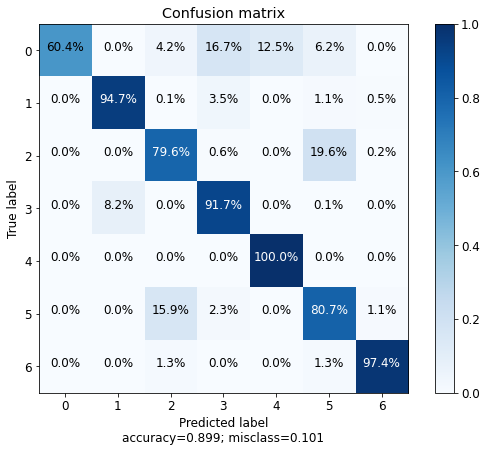

In [29]:
plot_confusion_matrix(cm)

# Reinforce Model
Train the model with person name data set.

In [0]:
name_link = '/content/drive/My Drive/Colab Notebooks/train/name_data.csv'
name_df = pd.read_csv(name_link, dtype = {'sentence': str, 'label': int})
name_df.columns = ['text', 'labels']
name_df[:10]

In [0]:
# Train the model
model.train_model(name_df, eval_df=eval_df)

In [0]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)
result

In [0]:
# get true/predict data value of labels.
predict_tag = model.predict(eval_df['text'])
predict_tag = predict_tag[0]
real_tag = eval_df['labels'].to_numpy()

In [0]:
# show confusion matrix
cm = confusion_matrix(real_tag, predict_tag)
plot_confusion_matrix(cm)

# Example of a prediction

In [30]:
# True
predictions, raw_outputs = model.predict(['JOHN'])
predictions, raw_outputs

(array([2]),
 array([[-2.6425781 , -1.6533203 ,  8.6171875 , -2.0957031 , -3.125     ,
          1.5126953 , -0.71972656, -4.0859375 ]], dtype=float32))

In [31]:
# True
predictions, raw_outputs = model.predict(['No thanks, I\'m not staying long.'])
predictions, raw_outputs

(array([3]),
 array([[-1.5302734,  0.3881836, -2.4980469, 10.265625 , -1.46875  ,
         -1.7460938, -2.7167969, -1.7714844]], dtype=float32))

In [32]:
# False
predictions, raw_outputs = model.predict(['FATHER GARRET and Angela have retreated to another area for privacy.'])
predictions, raw_outputs

(array([1]),
 array([[-2.2167969,  9.8125   , -2.0429688,  1.4511719, -1.8085938,
         -2.171875 , -2.4335938, -3.1582031]], dtype=float32))

In [33]:
# True
predictions, raw_outputs = model.predict(['ANGELA'])
predictions, raw_outputs

(array([2]),
 array([[-2.8046875 , -1.3603516 ,  8.4765625 , -1.8632812 , -3.2578125 ,
          1.7783203 , -0.76660156, -4.2890625 ]], dtype=float32))

In [34]:
# True
predictions, raw_outputs = model.predict(['THEOLOGICAL SOCIETY'])
predictions, raw_outputs

(array([5]),
 array([[-1.6181641 , -2.1464844 ,  0.15612793, -1.4365234 , -2.21875   ,
          5.6523438 , -0.09466553, -3.0996094 ]], dtype=float32))

In [36]:
# True -> FALSE -> True
predictions, raw_outputs = model.predict(['FADE IN:'])
predictions, raw_outputs

(array([0]),
 array([[ 9.5625    , -2.3359375 , -1.6621094 , -1.9941406 , -0.81933594,
         -0.5239258 , -0.34521484,  0.34399414]], dtype=float32))

In [38]:
# False -> True
predictions, raw_outputs = model.predict(['FADE IN'])
predictions, raw_outputs

(array([0]),
 array([[ 9.5546875 , -2.3085938 , -1.6328125 , -2.0878906 , -0.75878906,
         -0.43823242, -0.4267578 ,  0.16467285]], dtype=float32))

In [39]:
# True
predictions, raw_outputs = model.predict(['LATER'])
predictions, raw_outputs

(array([6]),
 array([[-1.7607422, -2.2207031, -1.1328125, -2.1796875, -2.34375  ,
         -0.5131836,  9.5390625, -1.9169922]], dtype=float32))

In [40]:
# True
predictions, raw_outputs = model.predict(['Our view RISES OVER him and gliding across the barren landscape are the SHADOW of WINGS.'])
predictions, raw_outputs

(array([1]),
 array([[-2.1992188,  9.625    , -2.0253906,  1.4384766, -1.8183594,
         -2.0976562, -2.4609375, -3.203125 ]], dtype=float32))

In [41]:
# True
predictions, raw_outputs = model.predict(['MATCH CUT TO:'])
predictions, raw_outputs

(array([0]),
 array([[ 8.6015625 , -3.1367188 ,  0.04342651, -3.0351562 , -1.4248047 ,
          1.1630859 , -0.5180664 , -0.7392578 ]], dtype=float32))

In [42]:
# True
predictions, raw_outputs = model.predict(['That\'s called pain.'])
predictions, raw_outputs

(array([3]),
 array([[-1.6230469,  0.6489258, -2.3535156, 10.5390625, -1.7265625,
         -1.9111328, -2.6738281, -1.9755859]], dtype=float32))

In [45]:
# True -> FALSE -> True
predictions, raw_outputs = model.predict(['PALACE'])
predictions, raw_outputs

(array([5]),
 array([[-1.7167969 , -2.1679688 ,  1.8085938 , -2.3847656 , -2.5859375 ,
          5.5742188 , -0.06463623, -3.2773438 ]], dtype=float32))

In [46]:
# True
predictions, raw_outputs = model.predict(['HARRY POTTER'])
predictions, raw_outputs

(array([2]),
 array([[-2.5390625 , -1.7216797 ,  4.8789062 , -2.0449219 , -2.9804688 ,
          4.3085938 , -0.79589844, -3.5449219 ]], dtype=float32))

In [47]:
# True
predictions, raw_outputs = model.predict(['Love means never having to say I\'m sorry.'])
predictions, raw_outputs

(array([3]),
 array([[-1.4677734 ,  0.60546875, -2.4980469 , 10.4140625 , -1.4990234 ,
         -2.1464844 , -2.7246094 , -1.8017578 ]], dtype=float32))

In [48]:
# True -> FALSE
predict_sentence = 'REVERSE ANGLE'
tagging_prediction, _ = model.predict([predict_sentence])
tagging_prediction

array([5])